In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, lognorm

In [2]:
z975 = norm.ppf(0.975)

**1.** Consider the data in Example 8.6. Find the plug-in estimate of the correlation coeﬃcient. Estimate the standard error using the bootstrap. Find a 95 percent confidence interval using the Normal, pivotal, and percentile methods.

In [3]:
lsat = [576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594]
gpa = [3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 3.96]
theta_hat = np.corrcoef(lsat, gpa)[0,1]

x = np.column_stack((lsat, gpa))

B = 1000
rng = np.random.default_rng(0)
idx = rng.integers(0, len(x), size=(B,len(x)))
boot = x[idx]
tBoot = np.array([np.corrcoef(b[:,0],b[:,1])[0,1] for b in boot])

# Alternatively,
# tBoot = []
# for _ in range(B):
#    xx = x[rng.choice(len(x), size=len(lsat), replace=True)]
#    xx1, xx2 = zip(*xx)
#    tBoot.append(np.corrcoef(xx1, xx2)[0,1])
# tBoot = np.array(tBoot)

se = tBoot.std(ddof=0)
q025, q975 = np.quantile(tBoot, [0.025, 0.975])

ci_norm = (theta_hat - z975 * se, theta_hat + z975 * se)
ci_perc = (q025, q975)
ci_pivo = (2 * theta_hat - q975, 2 * theta_hat - q025)

print(f'theta_hat: {theta_hat:.4f}')
print(f'se: {se:.4f}')
print(f'Normal: ({ci_norm[0]:.4f}, {ci_norm[1]:.4f})')
print(f'Percentile: ({ci_perc[0]:.4f}, {ci_perc[1]:.4f})')
print(f'Pivotal: ({ci_pivo[0]:.4f}, {ci_pivo[1]:.4f})')

theta_hat: 0.5459
se: 0.1967
Normal: (0.1604, 0.9315)
Percentile: (0.2133, 0.9347)
Pivotal: (0.1572, 0.8786)


**2.** Conduct a simulation to compare various bootstrap confidence interval methods. Let $n=50$ and let $T(F) = \frac{\int(x-\mu)^3 \, dF(x)}{\sigma^3}$ be the skewness. Draw $Y_1, \dots, Y_n \sim N(0,1)$ and set $X_i = e^{Y_i}$, $i = 1, \dots, n$. Construct the three types of bootstrap 95 percent intervals for $T(F)$ from the data $X_1, \dots, X_n$. Repeat this whole thing many times and estimate the true coverage of the three intervals.

In [4]:
n=50
m=100
B=1000
count_norm=count_perc=count_pivo=0
true_theta = (np.e + 2) * np.sqrt(np.e - 1)

for seed in range(m):

    rng = np.random.default_rng(seed)
    y = rng.normal(0,1,size=n)
    x = np.exp(y)
    theta_hat = np.mean(((x-np.mean(x))/x.std(ddof=0)) ** 3)
    
    idx = rng.integers(0, n, size=(B,n))
    boot = x[idx]
    boot_means = boot.mean(axis=1)
    boot_ses = boot.std(axis=1, ddof=0)
    boot_ses = np.where(boot_ses==0, 1.0, boot_ses)
    tBoot = np.mean(((boot - boot_means[:,None]) / boot_ses[:,None]) ** 3, axis=1)

    # Alternatively,
    # tBoot = np.array([np.mean(((b-np.mean(b))/b.std(ddof=0)) ** 3) for b in boot])

    se = tBoot.std(ddof=0)
    q025, q975 = np.quantile(tBoot, [0.025, 0.975])
    ci_norm = (theta_hat - z975 * se, theta_hat + z975 * se)
    ci_perc = (q025, q975)
    ci_pivo = (2 * theta_hat - q975, 2 * theta_hat - q025)

    count_norm += (ci_norm[0] < true_theta < ci_norm[1])
    count_perc += (ci_perc[0] < true_theta < ci_perc[1])
    count_pivo += (ci_pivo[0] < true_theta < ci_pivo[1])

print(f'Normal coverage: {count_norm/m:.4f}')
print(f'Percentile coverage: {count_perc/m:.4f}')
print(f'Pivotal coverage: {count_pivo/m:.4f}')

Normal coverage: 0.0900
Percentile coverage: 0.0300
Pivotal coverage: 0.1200


**3.** Let $X_1, \dots, X_n \sim t_3$ where $n=25$. Let $\theta = T(F) = (q_{.75} - q_{.25}) / 1.34$ where $q_p$ denotes the $p^{\text{th}}$ quantile. Do a simulation to compare the coverage and length of the bootstrap confidence intervals for $\theta$.

In [5]:
n=25
m=100
B=1000
count_norm=count_perc=count_pivo=0
len_norm=len_perc=len_pivo=0
true_theta = (t.ppf(q=0.75, df=3) - t.ppf(q=0.25, df=3))/1.34

for seed in range(m):

    rng = np.random.default_rng(seed)
    x = rng.standard_t(3,size=n)
    theta_hat = (np.quantile(x, 0.75) - np.quantile(x, 0.25))/1.34
    
    idx = rng.integers(0, n, size=(B,n))
    boot = x[idx]
    boot_quantiles = np.quantile(boot, [0.25,0.75], axis=1)
    tBoot = (boot_quantiles[1] - boot_quantiles[0])/1.34

    # Alternatively,
    # tBoot = np.array([(np.quantile(b, 0.75) - np.quantile(b, 0.25))/1.34 for b in boot])

    se = tBoot.std(ddof=0)
    q025, q975 = np.quantile(tBoot, [0.025, 0.975])
    ci_norm = (theta_hat - z975 * se, theta_hat + z975 * se)
    ci_perc = (q025, q975)
    ci_pivo = (2 * theta_hat - q975, 2 * theta_hat - q025)

    count_norm += (ci_norm[0] < true_theta < ci_norm[1])
    count_perc += (ci_perc[0] < true_theta < ci_perc[1])
    count_pivo += (ci_pivo[0] < true_theta < ci_pivo[1])
    
    len_norm += (ci_norm[1] - ci_norm[0])
    len_perc += (ci_perc[1] - ci_perc[0])
    len_pivo += (ci_pivo[1] - ci_pivo[0])

print(f'Normal coverage: {count_norm/m:.4f}, avg length: {len_norm/m:.4f}')
print(f'Percentile coverage: {count_perc/m:.4f}, avg length: {len_perc/m:.4f}')
print(f'Pivotal coverage: {count_pivo/m:.4f}, avg length: {len_pivo/m:.4f}')

Normal coverage: 0.9600, avg length: 1.2893
Percentile coverage: 0.9800, avg length: 1.2583
Pivotal coverage: 0.8200, avg length: 1.2583


**6.** Let $X_1, \dots, X_n \sim N(\mu,1)$. Let $\theta = e^\mu$ and let $\widehat{\theta} = e^{\overline{X}}$. Create a data set (using $\mu=5$) consisting of $n=100$ observations. (a) Use bootstrap to get the se and 95 percent confidence intervals for $\theta$. (b) Plot a histogram of the bootstrap replications. This is an estimate of the distribution of $\widehat{\theta}$. Compare this to the true sampling distribution of $\widehat{\theta}$.

theta_hat: 160.9505
se: 15.6318
Normal: (130.3126, 191.5883)
Percentile: (133.0567, 194.1714)
Pivotal: (127.7295, 188.8443)


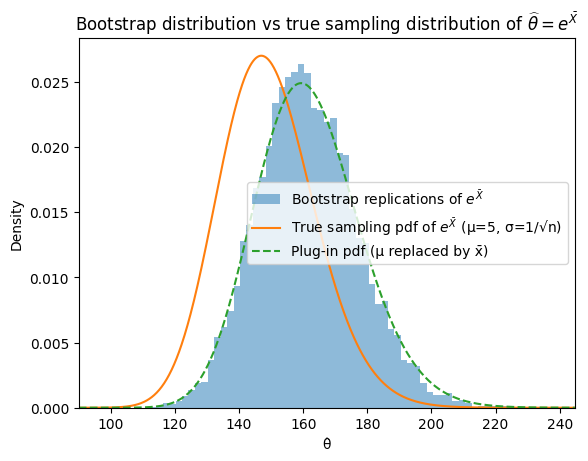

In [6]:
mu=5
n=100
B=10000

rng = np.random.default_rng(0)
x = rng.normal(mu,1,size=n)
mu_hat = x.mean()
theta_hat = np.exp(mu_hat)

idx = rng.integers(0, n, size=(B,n))
boot = x[idx]
boot_means = boot.mean(axis=1)
tBoot = np.exp(boot_means)

se = tBoot.std(ddof=0)
q025, q975 = np.quantile(tBoot, [0.025, 0.975])

ci_norm = (theta_hat - z975 * se, theta_hat + z975 * se)
ci_perc = (q025, q975)
ci_pivo = (2 * theta_hat - q975, 2 * theta_hat - q025)

print(f'theta_hat: {theta_hat:.4f}')
print(f'se: {se:.4f}')
print(f'Normal: ({ci_norm[0]:.4f}, {ci_norm[1]:.4f})')
print(f'Percentile: ({ci_perc[0]:.4f}, {ci_perc[1]:.4f})')
print(f'Pivotal: ({ci_pivo[0]:.4f}, {ci_pivo[1]:.4f})')

s_true = 1/np.sqrt(n)
y = np.linspace(np.exp(mu - 5*s_true), np.exp(mu + 5*s_true), 1000)
pdf_true = lognorm.pdf(y, s=s_true, scale=np.exp(mu))

# plug-in curve using mu_hat instead of mu
pdf_plugin = lognorm.pdf(y, s=s_true, scale=np.exp(mu_hat))

plt.figure()
plt.hist(tBoot, bins=60, density=True, alpha=0.5, label='Bootstrap replications of $e^{\\bar X}$')
plt.plot(y, pdf_true, label='True sampling pdf of $e^{\\bar X}$ (μ=5, σ=1/√n)')
plt.plot(y, pdf_plugin, linestyle='--', label='Plug-in pdf (μ replaced by x̄)')
# plt.xscale('log')
plt.xlim(y[0], y[-1])
plt.xlabel('θ̂')
plt.ylabel('Density')
plt.title('Bootstrap distribution vs true sampling distribution of $\\widehat{\\theta}=e^{\\bar X}$')
plt.legend()
plt.show()

**7.** Let $X_1, \dots, X_n \sim U(0,\theta)$. Let $\widehat{\theta} = X_{\text{max}} = \max \{ X_1, \dots, X_n \}$. Generate a data set of size 50 with $\theta=1$. Find the distribution of $\widehat{\theta}$. Compare the true distribution of $\widehat{\theta}$ to the histograms from the bootstrap.

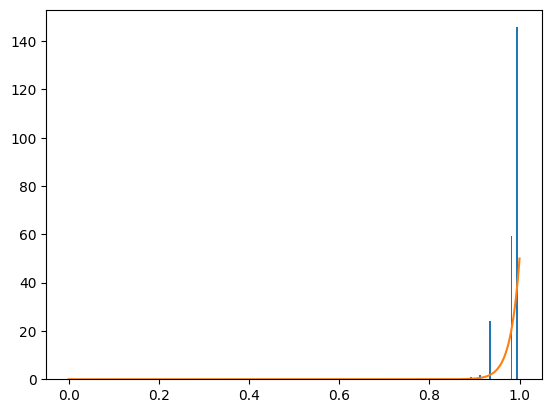

In [7]:
theta=1
n=50
B=1000

rng = np.random.default_rng(0)
x = rng.uniform(0, theta, size=n)
theta_hat = x.max()

idx = rng.integers(0, n, size=(B,n))
boot = x[idx]
tBoot = boot.max(axis=1)

y = np.linspace(0,1,1000)
pdf_theta_hat = n * y ** (n-1)

plt.figure()
plt.hist(tBoot, bins=25, density=True)
plt.plot(y, pdf_theta_hat)
plt.show()